# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- mettre au propre les commentaires de l'étape 3

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CORRECTION = 1 
SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 0.8
ROT_ACCURACY = 0.1
CHECK_ANGLE = math.pi / 2.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [6]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [7]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(549, 1080), (868, 1080), (868, 604), (549, 604)], [(1063, 1080), (1369, 1080), (1369, 615), (1063, 615)], [(0, 1080), (436, 1080), (436, 510), (0, 510)]]
Centroid de la goal area : [1630.  572.]
Vecteur direction du robot : 102 -9
Centroid du robot : [1007  186]


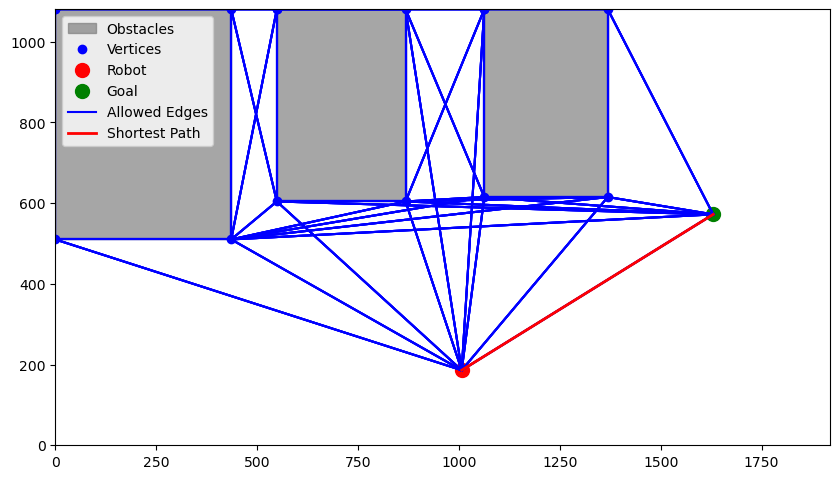

In [10]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration :  1
Kalman:  x:  54.0 , y:  10.0 , angle:  -0.08800737352774077
Rotation state:
Robot angle:  [-0.08800737] , Goal angle:  [0.53172407] , Rotation to achieve:  [0.61973144]
Iteration :  2
Kalman:  x:  53.98909584940548 , y:  10.000962130934811 , angle:  -0.08721286838861077
Rotation state:
Robot angle:  [-0.08721287] , Goal angle:  [0.53156292] , Rotation to achieve:  [0.61877579]
Iteration :  3
Kalman:  x:  53.98916533405228 , y:  10.001138202670221 , angle:  -0.06112700367267393
Rotation state:
Robot angle:  [-0.061127] , Goal angle:  [0.53155997] , Rotation to achieve:  [0.59268697]
Iteration :  4
Kalman:  x:  54.01244576427835 , y:  9.999619019665536 , angle:  0.004087672458154648
Rotation state:
Robot angle:  [0.00408767] , Goal angle:  [0.53189241] , Rotation to achieve:  [0.52780474]
Iteration :  5
Kalman:  x:  54.04339030390551 , y:  9.999463592560916 , angle:  0.08788388762793363
Rotation state:
Robot angle:  [0.08788389] , Goal angle:  [0.53229404] , Rotation to ac

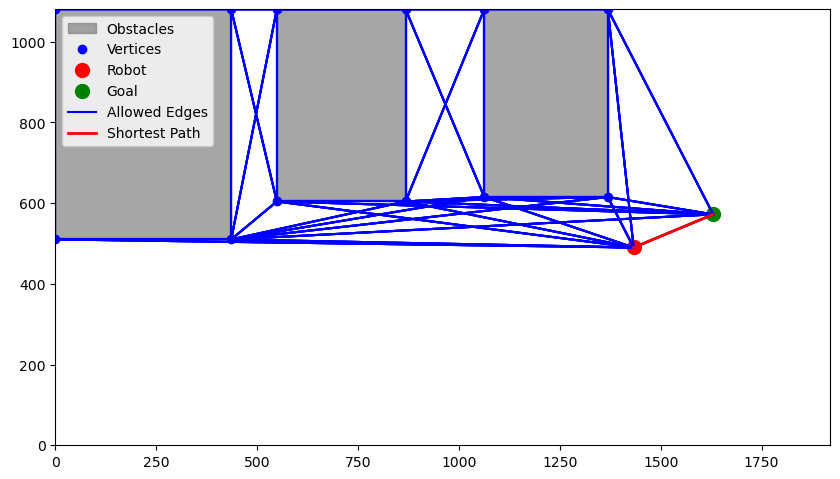

glob nav path : [(1433.0, 490.0), (1630.0, 572.0)]
camera measurements:  (77, 26) 0.5622848023425469
centroid camera:  (77, 26)
camera fin: [(88, 30)]
Iteration :  50
Kalman:  x:  77.00060177974132 , y:  26.000491157375535 , angle:  0.5630464640392304
Rotation state:
Robot angle:  [0.56304646] , Goal angle:  [0.34874914] , Rotation to achieve:  [-0.21429733]
Iteration :  51
Kalman:  x:  77.12644775699735 , y:  26.07992012368116 , angle:  0.5678984628893109
Rotation state:
Robot angle:  [0.56789846] , Goal angle:  [0.34601152] , Rotation to achieve:  [-0.22188695]
Iteration :  52
Kalman:  x:  77.28905063383176 , y:  26.1844136335033 , angle:  0.5664509917056372
Rotation state:
Robot angle:  [0.56645099] , Goal angle:  [0.34221617] , Rotation to achieve:  [-0.22423482]
Iteration :  53
Kalman:  x:  77.3770208766185 , y:  26.243450399658215 , angle:  0.5215548281037967
Rotation state:
Robot angle:  [0.52155483] , Goal angle:  [0.33990044] , Rotation to achieve:  [-0.18165438]
Iteration :  

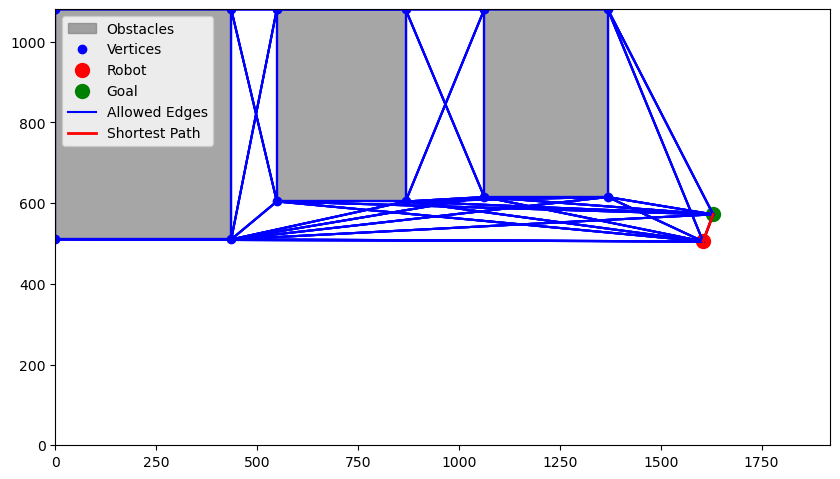

glob nav path : [(1605.0, 505.0), (1630.0, 572.0)]
camera measurements:  (86, 27) 0.13111164848254667
centroid camera:  (86, 27)
camera fin: [(88, 30)]
Iteration :  71
Kalman:  x:  86.00068073100478 , y:  27.000265385879985 , angle:  0.13225490317422922
Rotation state:
Robot angle:  [0.1322549] , Goal angle:  [0.98291001] , Rotation to achieve:  [0.8506551]
Iteration :  72
Kalman:  x:  86.41463395816692 , y:  27.05531467180686 , angle:  0.13124715621331728
Rotation state:
Robot angle:  [0.13124716] , Goal angle:  [1.0769165] , Rotation to achieve:  [0.94566934]
Iteration :  73
Kalman:  x:  86.77093020578243 , y:  27.09980462545779 , angle:  0.15641998517114922
Rotation state:
Robot angle:  [0.15641999] , Goal angle:  [1.16995218] , Rotation to achieve:  [1.01353219]
Iteration :  74
Kalman:  x:  86.92174409128977 , y:  27.122178399693034 , angle:  0.21740188751485856
Rotation state:
Robot angle:  [0.21740189] , Goal angle:  [1.21230815] , Rotation to achieve:  [0.99490626]
Iteration :  

/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/benoitgallois/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:93: RuntimeWarning: invalid value encountered in cast
  direction = (front_centroid - back_centroid).astype(int)
/Users/benoitgallois/Desktop/EPFL/MA3/Mobile Robotics/Projet - Vision/Code final/vision.py:94: RuntimeWarning: invalid value encountered in cast
  midpoint = ((front_centroid + back_centroid) / 2).astype(int)


Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 0 0
Centroid du robot : [0 0]
Vecteur direction du robot : 19 84
Centroid du robot : [1601  593]


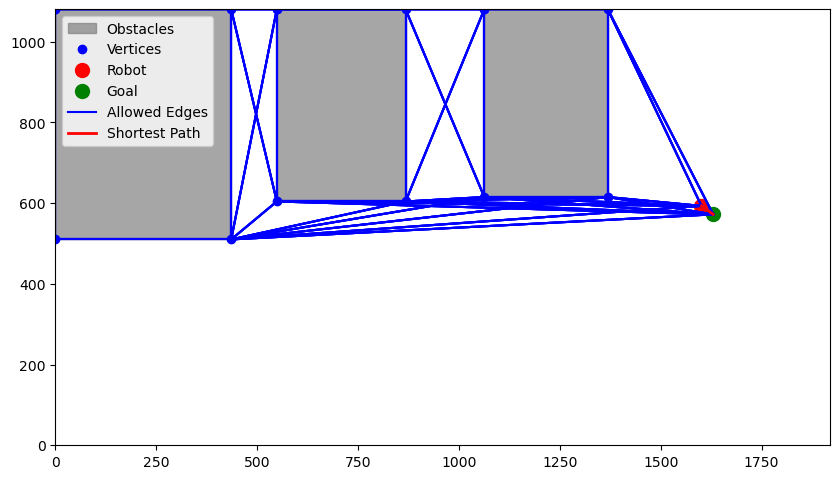

glob nav path : [(1601.0, 593.0), (1630.0, 572.0)]
camera measurements:  (86, 32) 1.348349061368955
centroid camera:  (86, 32)
camera fin: []
Iteration :  93
Thymio arrived in the goal area, congratulations!


In [11]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)


old_time = 0.0
iter = 0


while(True):
    
    if iter == 0:                   
        old_time = time.time()
        
    dt = time.time() - old_time     # get time difference for Kalman -> A METTRE DANS UNE FONCTION
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter = iter + 1
    print("Iteration : ", iter)

    # Check if the robot is arrived to the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        break
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    # Prox sensors detect something, we call the local navigation
    if detected == True:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE
        #continue

    #CA SERT A QUOI RAPH? A mettre dans une fonction?
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * SPEED_CORRECTION
    speed_left_meas = speed_left_meas * SPEED_CORRECTION
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    
    
    print("Kalman: ", "x: ", Kfilter.Mu[0][0], ", y: ", Kfilter.Mu[1][0], ", angle: ", Kfilter.Mu[2][0])
    
    # Robot receive the value from Kalman estimation
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    
    
    if global_state == ROTATION_STATE:
        print("Rotation state:")
        # Compute the difference between the robot direction and the direction of the goal
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], 
                           intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print("Robot angle: ", Kfilter.Mu[2], ", Goal angle: ", 
              np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), 
              ", Rotation to achieve: ", angle)
        
        if(abs(angle) < ROT_ACCURACY):
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue

        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise

        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise

            
    elif global_state == TRANSLATION_STATE:
        
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]

        
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
        
    elif global_state == CAMERA_STATE:
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        print("glob nav path :", shortest_path)
        
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = ROTATION_STATE
        continue
        
        
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
    
        obstacles.append(Object)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [12]:
await stop_robot()